# Part I : Datasets preparation

## Install required packages:

In [ ]:
!conda install -c conda-forge folium

In [ ]:
#!conda install -c conda-forge folium=0.5.0 --yes
import pandas as pd
import numpy as np
import requests
from sklearn.cluster import KMeans
import folium
from geopy.geocoders import Nominatim
import json
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors

### Police districts and Boston neighborohoods retrieval:

In [ ]:
df1 = pd.read_csv('http://bostonopendata-boston.opendata.arcgis.com/datasets/e5a0066d38ac4e2abbc7918197a4f6af_6.csv')

In [ ]:
df1 = df1[['Y', 'X', 'NAME', 'NEIGHBORHOOD']]
df1.sort_values(by = 'NAME', inplace = True)
df1.rename(columns = {'NEIGHBORHOOD': 'District'}, inplace = True)
df1 = df1.drop(df1[df1.NAME == 'Boston Police Headquarters'].index)

In [ ]:
df1['NAME'] = df1['NAME'].str.extract(r'\s(.*?)\s', expand=False)
df1['NAME'] = df1['NAME'].str.replace('-','')

In [ ]:
df1['District'] = df1['District'].str.replace('Brighton','Allston/Brighton')

In [ ]:
df1.head() # df1 uses far for name police station markers

In [ ]:
df1_fin = df1[['NAME','District']]
df1_fin #uses far

### Gegraphic neighborohoods (districts) retrieval:

In [ ]:
!wget --quiet http://bostonopendata-boston.opendata.arcgis.com/datasets/a6488cfd737b4955bf55b0342c74575b_0.geojson -O boston_geo.json

In [ ]:
distr = []
with open ('boston_geo.json') as f:
    data = json.load(f)

for feature in data['features']:
    distr.append(feature['properties']['PD'])
df2 = pd.DataFrame(distr, columns = ['District'])

In [ ]:
df2

### Mapping between all Boston neighborohoods (districts) and police districts:

In [ ]:
df_res = pd.merge(df2, df1_fin, on='District', how='left')

df_res

### Correcting NaNs by using info from wikipedia - https://en.wikipedia.org/wiki/Boston_Police_Department :

In [ ]:
df_res.loc[(df_res.District == 'Central') | (df_res.District == 'Harbor Islands'),'NAME'] = 'A1'
df_res.loc[(df_res.District == 'South End') | (df_res.District == 'Fenway/Kenmore') | (df_res.District == 'Back Bay/Beacon Hill'), 'NAME'] = 'D4'    
df_res.loc[(df_res.District == 'South Dorchester') | (df_res.District == 'North Dorchester'),'NAME'] = 'C11'
df_res.loc[df_res['District'] == 'Roslindale', 'NAME'] = 'E5'

In [ ]:
df_res

### 2018-2019 Total crime per Boston police district retrieval:

In [ ]:
df3 = pd.read_csv('https://data.boston.gov/dataset/6220d948-eae2-4e4b-8723-2dc8e67722a3/resource/12cb3883-56f5-47de-afa5-3b1cf61b257b/download/tmpzo7dbtvq.csv',
                  index_col=False)

In [ ]:
df3 = df3[df3['YEAR'] > 2017] #take 2018 and 2019 years crime only

In [ ]:
df3.head()

In [ ]:
df3.rename(columns = {'DISTRICT': 'NAME'}, inplace = True)


In [ ]:
df3.sort_values(by = 'NAME', inplace = True)

In [ ]:
df3_res = df3[['NAME','INCIDENT_NUMBER']]
df3_res.head()

In [ ]:
df3_fin = df3_res.groupby('NAME').count()

In [ ]:
df3_fin = df3_fin.reset_index()

In [ ]:
df3_fin.drop(df3_fin[df3_fin['NAME'] == 'External'].index, inplace = True)

In [247]:
df3_fin

,NAME,INCIDENT_NUMBER
0,A1,20867
1,A15,3724
2,A7,7082
3,B2,29342
4,B3,21344
5,C11,24014
6,C6,13724
7,D14,11535
8,D4,23529
9,E13,10271


### Total crime incidents per neighborohoods (districts) retrieval:

In [254]:
df_fin = pd.merge(df_res, df3_fin, on='NAME')

df_fin #need for choropleth

In [256]:
df_fin

,District,NAME,INCIDENT_NUMBER
1,Charlestown,A15,3724
0,East Boston,A7,7082
14,Roslindale,E5,7792
15,West Roxbury,E5,7792
9,Jamaica Plain,E13,10271
16,Hyde Park,E18,10593
8,Allston/Brighton,D14,11535
2,South Boston,C6,13724
4,Harbor Islands,A1,20867
3,Central,A1,20867


# Part II: Choropleth map of Boston neighborohoods crime data 2018-2019

In [ ]:
address = 'Boston, MA'

geolocator = Nominatim(user_agent="bos_explorer")
location = geolocator.geocode(address)
latitude_b = location.latitude
longitude_b = location.longitude
print('The geograpical coordinate of Boston are {}, {}.'.format(latitude_b, longitude_b))

### Getting geojson file with neighborohoods borders 

In [ ]:
response = requests.get('http://bostonopendata-boston.opendata.arcgis.com/datasets/a6488cfd737b4955bf55b0342c74575b_0.geojson')
bos_geo = response.json()

### Map creation:

In [ ]:
map_boston = folium.Map(location=[latitude_b, longitude_b], zoom_start=13)
#Crime rate vizualization
folium.Choropleth(
    geo_data=bos_geo,
    name = 'choropleth',
    data=df_fin,
    columns=['District', 'INCIDENT_NUMBER'],
    key_on='feature.properties.PD',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Boston crime incidents 2018-2019'
).add_to(map_boston)

#Districts borders:

layer_geom = folium.FeatureGroup(name='Dist-s borders',control= True)
list_tooltip_vars = []
for i in range(len(bos_geo["features"])):
    temp_geojson = {"features":[bos_geo["features"][i]],"type":"FeatureCollection"}
    temp_geojson_layer = folium.GeoJson(temp_geojson,
                   highlight_function=lambda x: {'weight':3, 'color':'black'},
                    control=False,
                    style_function=lambda feature: {
                   'color': 'black',
                   'weight': 1},
                    tooltip=folium.features.GeoJsonTooltip(fields=list_tooltip_vars,
                                        aliases=[x.capitalize()+":" for x in list_tooltip_vars], 
                                          labels=True, 
                                          sticky=False))
    folium.Popup(temp_geojson["features"][0]["properties"]["PD"]).add_to(temp_geojson_layer)
    temp_geojson_layer.add_to(layer_geom)
layer_geom.add_to(map_boston)

folium.LayerControl(autoZIndex=False, collapsed=True).add_to(map_boston)
map_boston
#type(map_boston)

# Part III: Getting coordinates for clusters

### Processing data set with public libraries as the centers of neighborohoods:

In [ ]:
df_lib = pd.read_csv('http://bostonopendata-boston.opendata.arcgis.com/datasets/cb00f9248aa6404ab741071ca3806c0e_6.csv')
df_lib = df_lib[['X', 'Y', 'DISTRICT', 'BRANCH']]
df_lib.head(2)

### Creating temporary map with public libraries marks:

In [ ]:
marks_only_map = folium.Map(location=[latitude_b, longitude_b], zoom_start=13)
folium.Choropleth(
    geo_data=bos_geo,
    name = 'choropleth',
    data=df_fin,
    columns=['District', 'INCIDENT_NUMBER'],
    key_on='feature.properties.PD',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Boston crime incidents 2018-2019'
).add_to(marks_only_map)

lt = list(df_lib.Y)
lg = list(df_lib.X)
lls = list(df_lib.DISTRICT)
lls1 = list(df_lib.BRANCH)

feature_group = folium.FeatureGroup(name='Public Libraries',control= True)
for lt, lg, l, l1 in zip(lt, lg, lls, lls1):
    folium.Marker([lt, lg],popup=[l, l1]).add_to(feature_group)

    
feature_group.add_to(marks_only_map)
folium.LayerControl(autoZIndex=False, collapsed=True).add_to(marks_only_map)
marks_only_map

### Removal of extra points, rename according appropriate neighborohoods (districts) map

In [ ]:
to_drop = ['West End','Honan-Allston', 'Faneuil', 'Parker Hill', 'Jamaica Plain', 'Dudley', 'Grove Hall',
           'Fields Corner', 'Codman Square', 'Lower Mills']
for i in range(0,len(to_drop)):
    df_lib.drop(df_lib[df_lib.BRANCH == to_drop[i]].index, inplace = True)
    
df_lib['BRANCH'] = df_lib['BRANCH'].str.replace('Brighton','Allston/Brighton')
df_lib['BRANCH'] = df_lib['BRANCH'].str.replace('Egleston Square','Roxbury')
df_lib['BRANCH'] = df_lib['BRANCH'].str.replace('Uphams Corner','North Dorchester')
df_lib['DISTRICT'] = df_lib['DISTRICT'].str.replace('COPLEY SQUARE','CENTRAL')


ind = []
for i in df_lib.loc[df_lib['DISTRICT'] == " "].index:
    ind.append(i)
df_lib['DISTRICT'].mask(df_lib['DISTRICT'] == " ", df_lib.BRANCH[ind], inplace=True)
df_lib['DISTRICT'] = df_lib['DISTRICT'].str.upper()


df_lib.rename(columns = {'X' : 'Longitude', 'Y': 'Latitude', 'DISTRICT' : 'NEIGH'}, inplace = True)
del df_lib['BRANCH']


In [ ]:
df_lib.head(3)

In [ ]:
df_lib.reset_index(inplace = True)

### Adding cluster centers to main map:

In [ ]:
lat = list(df_lib.Latitude)
long = list(df_lib.Longitude)
labels = list(df_lib.NEIGH)

for ltt, lng, lab in zip(lat, long, labels):
    folium.Marker([ltt, lng],
                  popup = lab).add_to(map_boston)

map_boston

# Part IV: Clusters processing:

In [ ]:
CLIENT_ID = 'NZDQSGAU3EWXT0QIX0323PSYHEPD5TDVCLYX21O5BEBU22Q4' # your Foursquare ID
CLIENT_SECRET = 'WPKHRS1DRIIUKMHJG3OJ4NHGD2XXB5BE2G3KFBZVPL2A4HDC' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 1000 #

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius = 1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
#        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['NEIGH', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
bos_venues = getNearbyVenues(names=df_lib['NEIGH'], latitudes=df_lib['Latitude'], longitudes=df_lib['Longitude'])

In [ ]:
bos_venues.head()

In [ ]:
bos_venues.shape

In [ ]:
bos_venues.groupby('NEIGH').count()

In [ ]:
print('There are {} uniques categories.'.format(len(bos_venues['Venue Category'].unique())))

In [164]:
df_viz = bos_venues.groupby('NEIGH').count()

In [165]:
df_viz.reset_index(inplace = True)

In [166]:
df_viz = df_viz[['NEIGH', 'Venue']]
df_viz.sort_values(by = 'Venue', inplace = True)
df_viz.set_index('NEIGH', inplace = True)

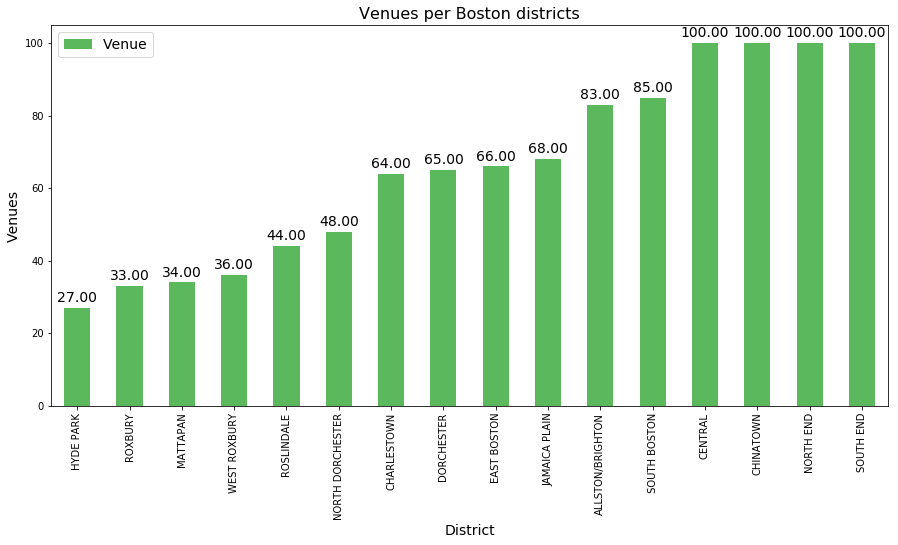

In [167]:
import matplotlib as mpl
import matplotlib.pyplot as plt
bcolors = ['#5cb85c','#5bc0de','#d9534f']
bwidth = 0.5

ax = df_viz.plot(kind='bar', figsize=(15, 7), color = bcolors, width = bwidth, legend=True)

ax.set_title("Venues per Boston districts", fontsize = 16)
ax.set_ylabel('Venues', fontsize = 14)
ax.set_xlabel('District', fontsize = 14)
ax.legend(fontsize = 14)
for p in ax.patches:
    #ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()))
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),fontsize=14, ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax

In [ ]:
bos_onehot = pd.get_dummies(bos_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bos_onehot['NEIGH'] = bos_venues['NEIGH'] 

# move neighborhood column to the first column
fixed_columns = [bos_onehot.columns[-1]] + list(bos_onehot.columns[:-1])
bos_onehot = bos_onehot[fixed_columns]

bos_onehot.head()

In [ ]:
bos_grouped = bos_onehot.groupby('NEIGH').mean().reset_index()
bos_grouped.head()

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
num_top_venues = 10


indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['NEIGH']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['NEIGH'] = bos_grouped['NEIGH']

for ind in np.arange(bos_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bos_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(2)

In [ ]:
bos_grouped_clustering = bos_grouped.drop('NEIGH', 1)

In [ ]:
bos_grouped_clustering.head()

In [ ]:
#from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist  
#import matplotlib.pyplot as plt

In [ ]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,17) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(bos_grouped_clustering) 
    kmeanModel.fit(bos_grouped_clustering)     
      
    distortions.append(sum(np.min(cdist(bos_grouped_clustering, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / bos_grouped_clustering.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(bos_grouped_clustering, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / bos_grouped_clustering.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val)) 


plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

for key,val in mapping2.items(): 
    print(str(key)+' : '+str(val)) 

plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

In [ ]:
from sklearn.metrics import silhouette_score

silt = []
kmax = 15
K = []
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(bos_grouped_clustering)
  labels = kmeans.labels_
  silt.append(silhouette_score(bos_grouped_clustering, labels, metric = 'euclidean'))
  K.append(k)
print (silt)
plt.plot(K, silt) 
plt.xlabel('Values of K') 
plt.ylabel('siluette') 
plt.title('The Method using siluette') 
plt.show() 

In [ ]:
kclusters = 3

bos_grouped_clustering = bos_grouped.drop('NEIGH', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bos_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

In [ ]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bos_merged = df_lib

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
bos_merged = bos_merged.join(neighborhoods_venues_sorted.set_index('NEIGH'), on='NEIGH')

bos_merged.head(2) # check the last columns!

In [246]:
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(bos_merged['Latitude'], bos_merged['Longitude'], bos_merged['NEIGH'], bos_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_boston)
       
map_boston

# Part V: Cluster analisys:

### Preprocessing for vizualization:

In [242]:
def cluster_details(cluster_label):
    df_cl = bos_merged.loc[bos_merged['Cluster Labels'] == cluster_label, bos_merged.columns[[3] + list(range(4, bos_merged.shape[1]))]]
    del df_cl['Cluster Labels']
    del df_cl['NEIGH']
    df_cl = df_cl.apply(pd.value_counts)
    df_cl['Total'] = df_cl.sum(axis=1)
    df_cl.sort_values(by = 'Total', inplace = True)
    cl_viz = df_cl['Total'].plot (kind = 'barh', color = ['g', 'b', 'y'], figsize=(15, 7), width = 0.6)
    return (cl_viz)

### Cluster 0:

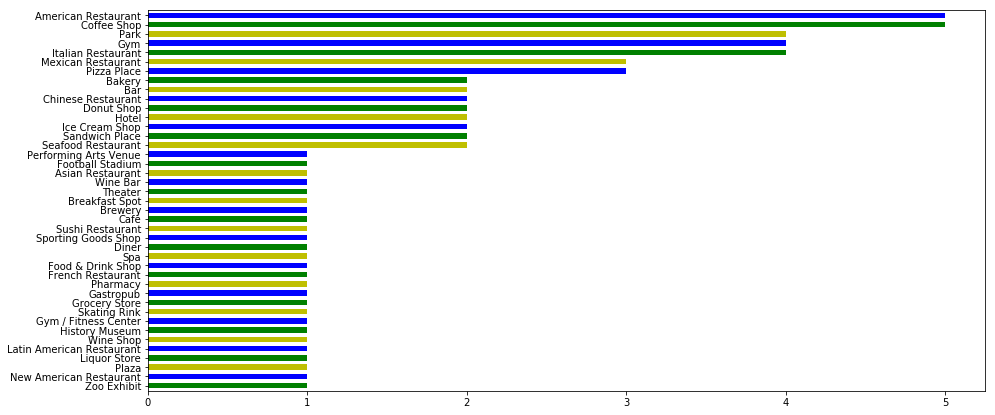

In [243]:
cl_viz1 = cluster_details(0)

### Cluster 1:

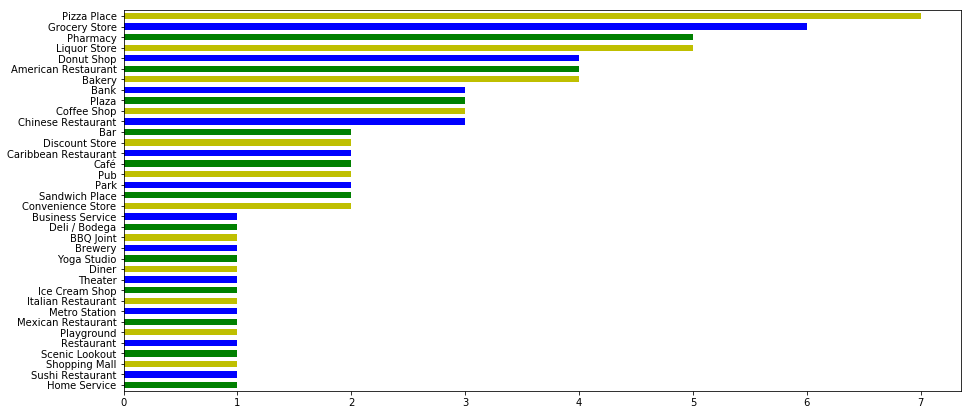

In [244]:
cl_viz2 = cluster_details(1)

### Cluster 2:

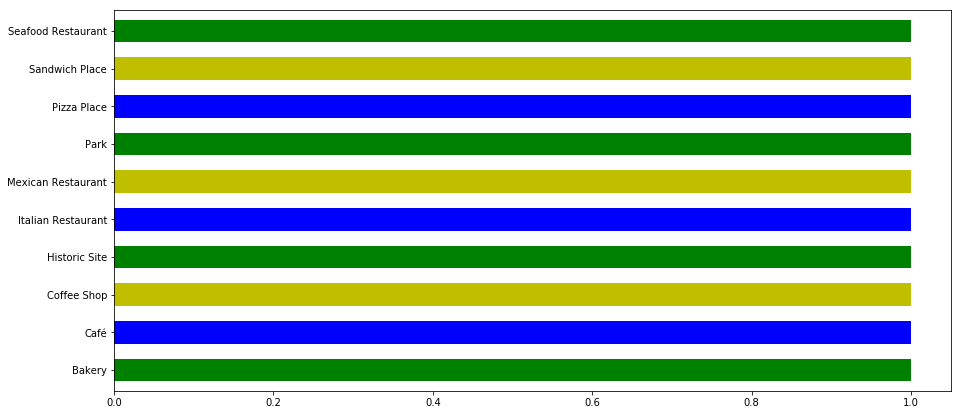

In [245]:
cl_viz3 = cluster_details(2)

In [215]:
df_cl0 = bos_merged.loc[bos_merged['Cluster Labels'] == 0, bos_merged.columns[[3] + list(range(4, bos_merged.shape[1]))]]
df_cl0
del df_cl0['Cluster Labels']
del df_cl0['NEIGH']
df_cl0 = df_cl0.apply(pd.value_counts)
df_cl0['Total'] = df_cl0.sum(axis=1)
df_cl0.sort_values(by = 'Total', ascending = False, inplace = True)
df_cl0['Total'].plot (kind = 'bar', color = ['g', 'b', 'y'], figsize=(18, 8), width = 0.8)

# Coordinates for clusters

# Wrong coordinates

In [ ]:
!wget --quiet https://opendata.arcgis.com/datasets/acedd06b39854088b0f2fefccffebf84_0.geojson -O boston_commc_geo.json
commc = []
commcg = []
with open ('boston_commc_geo.json') as f:
    data = json.load(f)

for feature in data['features']:
    commc.append(feature['properties'])
    commcg.append(feature['geometry'])
df4 = pd.DataFrame(commc)
df5 = pd.DataFrame(commcg)
df_comm = pd.concat([df4, df5], axis = 1)
df_comm = df_comm[['NEIGH', 'ZIP', 'coordinates']]
df_comm.sort_values(by = ['NEIGH', 'ZIP'], inplace = True)
df_comm.drop_duplicates(subset ="ZIP",inplace = True)
df_comm.drop_duplicates(subset ='NEIGH',inplace = True)
df_comm.reset_index(drop = True)
y_lst = []
x_lst = []
for xc in df_comm['coordinates'].values:
    x_lst.append(xc[0])
    y_lst.append(xc[1])
df_comm['Latitude'] = y_lst
df_comm['Longitude'] = x_lst
df_boston = df_comm[['NEIGH', 'Latitude','Longitude']]
df_boston.reset_index(drop = True)
'''
latit = list(df_boston.Latitude)
longit = list(df_boston.Longitude)
labels = list(df_boston.NEIGH)
#labels1 = list(df_boston.ZIP)

for lt, lg, lbl in zip(latit, longit, labels):
    folium.Marker([lt, lg],popup=lbl).add_to(map_boston)
map_boston
'''

In [ ]:
#Police stations vizualization as markers
'''
latitudes = list(df1.Y)
longitudes = list(df1.X)
labels = list(df1.District)
labels1 = list(df1.NAME)

for lat, lng, label,label1 in zip(latitudes, longitudes, labels, labels1):
    folium.Marker([lat, lng],
                  popup=[label,label1]
                 ).add_to(map_boston)
'''